In [7]:
import torch

from rl4co.envs import TSPkoptEnv
from rl4co.models import NeuOptPolicy, NeuOpt
from rl4co.utils.trainer import RL4COTrainer

In [8]:
env = TSPkoptEnv(generator_params=dict(num_loc=20), k_max=4)
model = NeuOpt(
        env,
        train_data_size=10,
        val_data_size=10,
        test_data_size=10,
        n_step=2,
        T_train=4,
        T_test=4,
        CL_best=True,
    )

/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critic'])`.


Problem 1 | Cost: -10.489
Problem 2 | Cost: -11.785
cuda


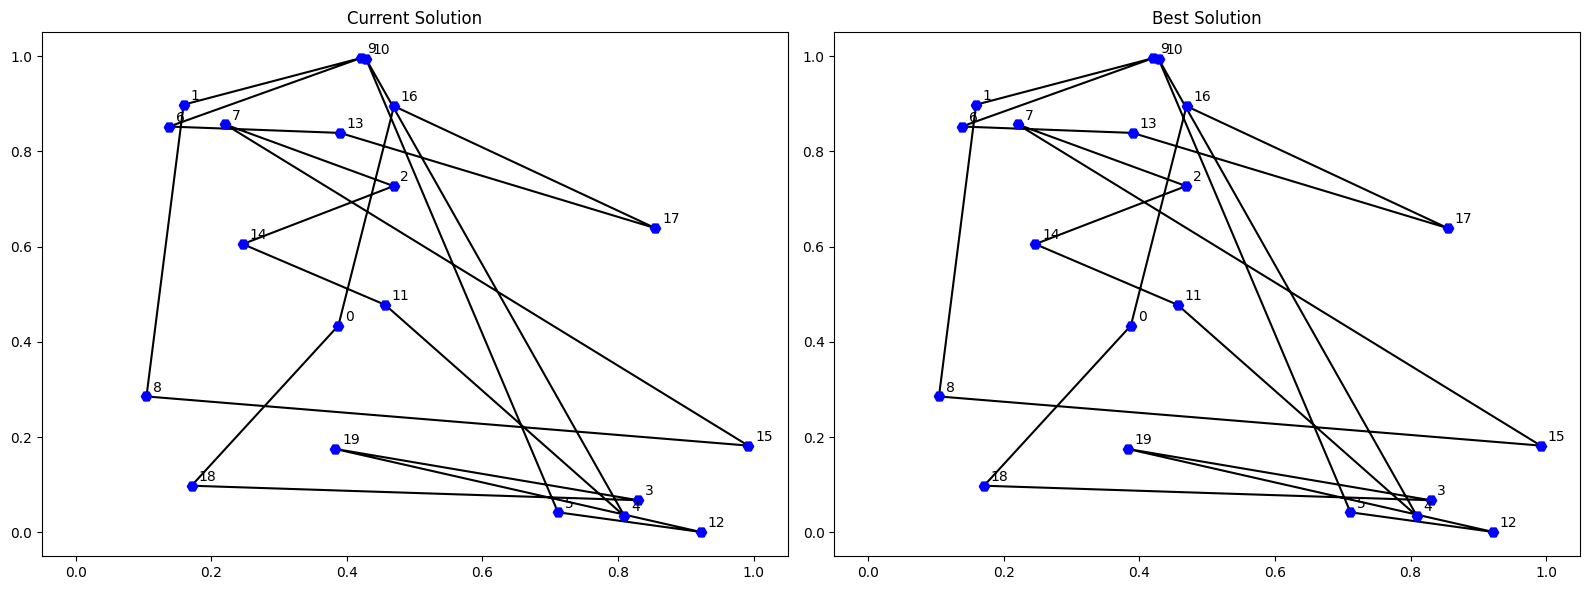

In [9]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[2]).to(device)
policy = model.policy.to(device)
out = policy(td_init.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)

actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['cost_bsf'].cpu().detach()


for i in range(2):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")

env.render(td_init.cpu(), actions_untrained.cpu())

print(device)

In [10]:
trainer = RL4COTrainer(
    max_epochs=3,
    gradient_clip_val=0.05,
    devices=1,
    accelerator="auto",
)

Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
trainer.fit(model)
trainer.test(model)

Overriding gradient_clip_val to None for 'automatic_optimization=False' models
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.

  | Name   | Type          | Params | Mode 
-------------------------------------------------
0 | env    | TSPkoptEnv    | 0      | train
1 | policy | NeuOptPolicy  | 682 K  | train
2 | critic | CriticNetwork | 140 K  | train
-------------------------------------------------
822 K     Trainable params
0         Non-trainable params
822 K     Total params
3.291     Total estimated model params size (MB)
94        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shora/Research/rl4co/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/cost_bsf       │     9.120078086853027     │
└───────────────────────────┴───────────────────────────┘

[{'test/cost_bsf': 9.120078086853027}]

Cost: -10.489
Cost: -10.489
Cost: -10.489
Cost: -10.489
Cost: -10.489
Cost: -10.489
Cost: -10.489
Cost: -10.489
Cost: -10.437
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461
Cost: -9.461


<Axes: title={'center': 'Best Solution'}>

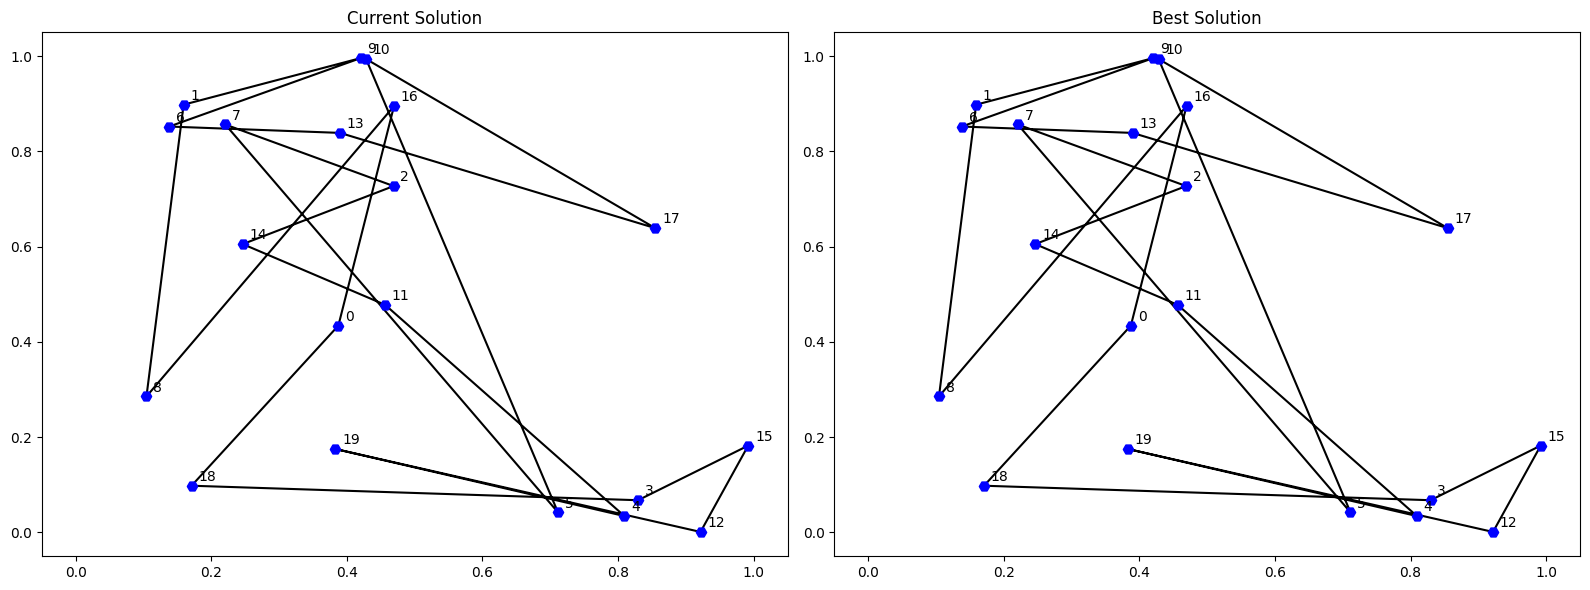

In [12]:

policy = model.policy.to(device)
out = None
for i in range(20):
    out = policy(td_init.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)
    td_init["action"] = out['actions']
    env.step(td_init)
    print(f"Cost: {-out['cost_bsf'][0].cpu().detach():.3f}")

env.render(td_init.cpu(), out['actions'].cpu())
